In [40]:
import sys
sys.path.append('..')
import theano.tensor as T
import theano
import numpy
import theano_lstm
import numpy as np
import data_managers
import os
import cPickle

# Plotting
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

In [2]:
net = theano_lstm.lstm_rnn( 300, [(128,128)], 150, save_weights_every=50000)

//anaconda/lib/python2.7/site-packages/theano/scan_module/scan_perform_ext.py:133: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


In [3]:
%%time
net.initialize_training_adam()

CPU times: user 2min 33s, sys: 2.31 s, total: 2min 35s
Wall time: 2min 38s


In [21]:
reload(data_managers)
data_butler = data_managers.character_data_manager('/Users/alex/Desktop/data manager/',
                                                   batch_size=1,perms_per=5,minmax_doc_length=[0,300])
data_butler.convert_ent_to_one_hot()

Now offering: Training data!


In [43]:
with open( data_butler.load_path + 'entity_vectors.pkl', 'rb' ) as f:
    ent_vecs = cPickle.load(f)
with open( data_butler.load_path + 'bad_entity_vectors.pkl', 'rb' ) as f:
    bEnt_vecs = cPickle.load(f)

In [44]:
data_butler.ent_vecs = ent_vecs
data_butler.bEnt_vecs = bEnt_vecs

In [22]:
def smooth_rep(data,sigma):
    w = np.ceil(2*sigma)
    f = np.exp( -.5*(np.arange(-w,w)**2)/(sigma**2) )
    f = f / np.sum(f)

    y = np.convolve(data,f,'valid')
    x = np.arange(w,len(data)-w+1)
    return x, y

In [74]:
# Re-initialize the network
net.initialize_network_weights(scale_down=0.6, b_f_offset=0.75)
net.save_weights_every = 100000000

# Initialize cost 
cost = []

data_butler.set_batch_size(1)
data_butler.set_perms_per(2)

Batch Size = 1;  Stride = 1
2 examples per offer: Batch Size = 1  *  Permutations per = 2


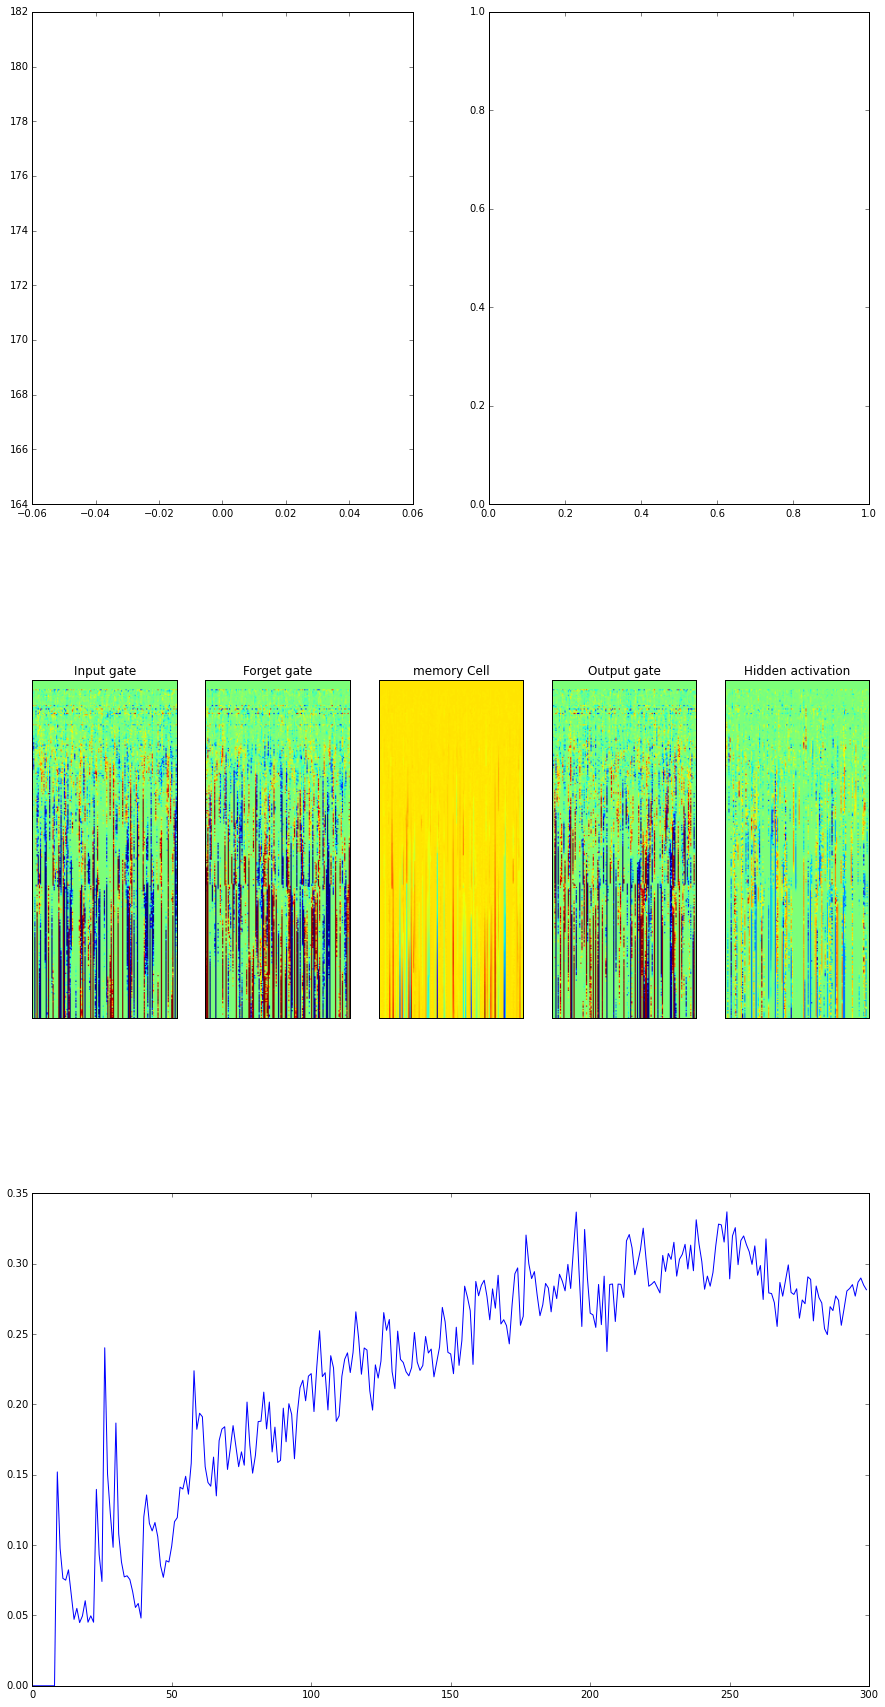

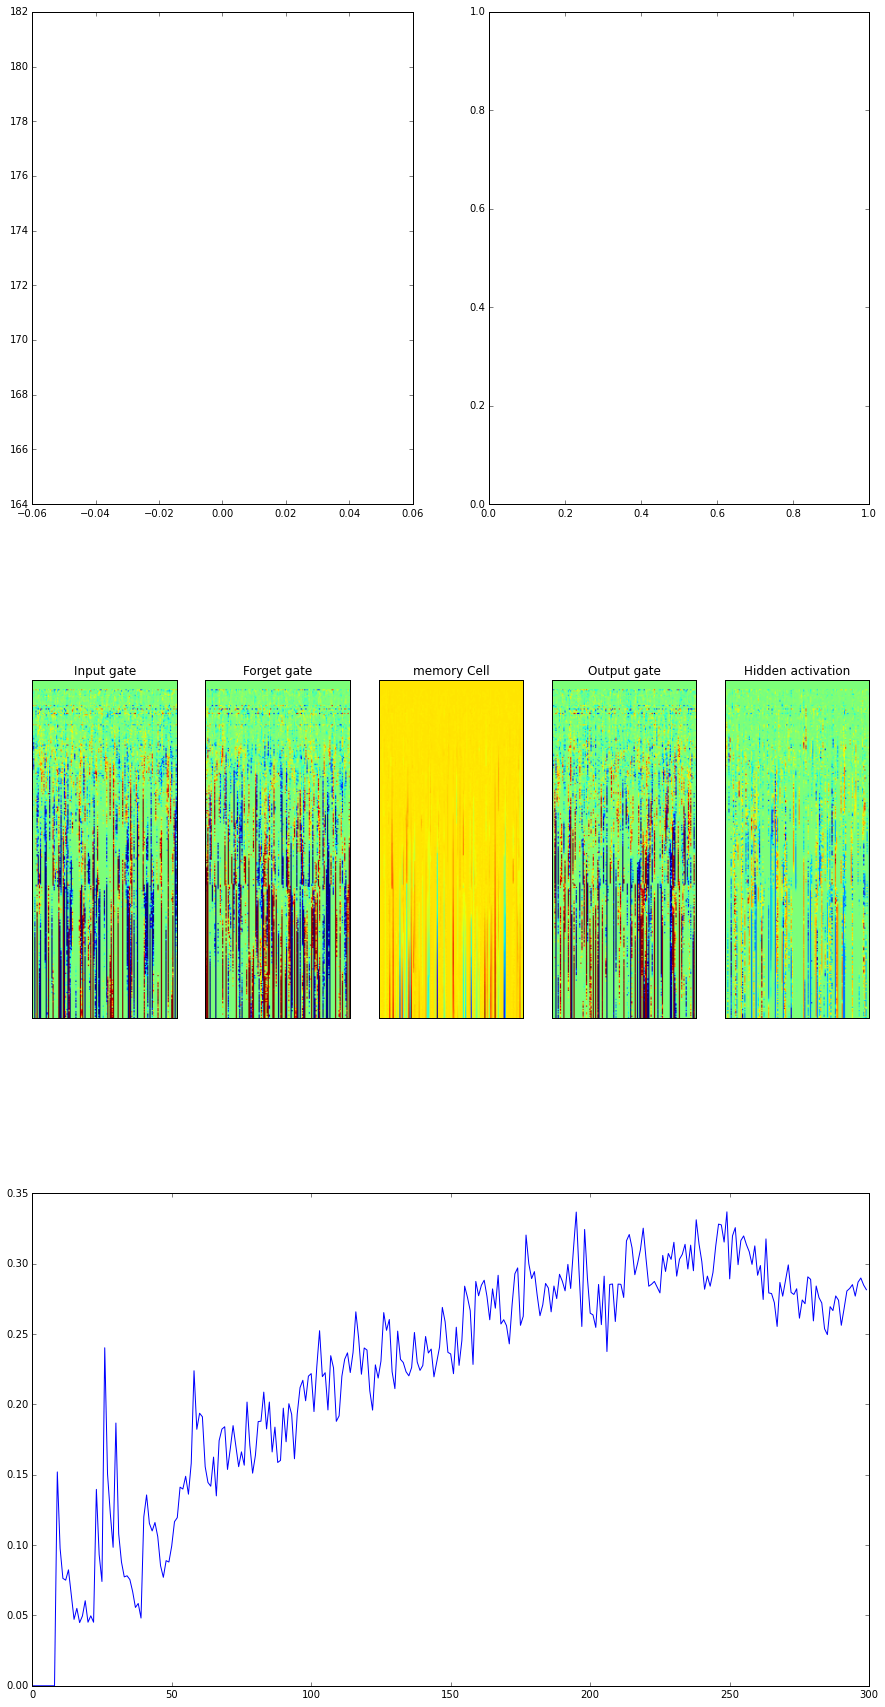

In [75]:
n_batches = 1

start_plot_at = 0
smooth_sigma = 15

#Create plot 
fig = plt.figure(figsize=(15,30))
axB = fig.add_subplot(321)
axS = fig.add_subplot(322)
fig.subplots_adjust(wspace=.2)

labels = ['Input gate','Forget gate','memory Cell','Output gate','Hidden activation']
ax_list = []
for sp in range(len(labels)):
    ax_list.append(fig.add_subplot(3,len(labels),(1*len(labels))+sp+1))

axD = fig.add_subplot(3,1,3)

for batch in range(n_batches):
    
    # Get the permuted data
    vectors, lengths, answer = data_butler.offer_data()
    
    # Step 
    temp_cost,_ = net.adam_step(vectors, lengths, answer)
    cost.append(temp_cost)
    
    # Update plot
    if len(cost) > start_plot_at:
        C = 100.* np.array(cost[start_plot_at:]) / .04004
    else:
        C = 100.* cost / .04004
    x, y = smooth_rep( C, smooth_sigma )
    axB.cla();
    axS.cla();
    if len(x) == len(y):
        axB.plot( np.arange(start_plot_at,len(cost)), C, 'b', x+start_plot_at, y, 'r')
        axS.plot( x+start_plot_at, y, 'r')
    else:
        axB.plot( np.arange(start_plot_at,len(cost)), C, 'b' )

    hidden_players = net.hidden_activations(vectors[:,:,:2])
    for ax,gtp,title in zip(ax_list, hidden_players, labels):
        ax.imshow(gtp[:lengths[1],:,1]-gtp[:lengths[0],:,0])
        ax.set_title(title)
        ax.set_yticks([])
        ax.set_xticks([])

    axD.cla();
    axD.plot( np.mean(np.abs(hidden_players[4][:lengths[1],:,1]-hidden_players[4][:lengths[0],:,0]),axis=1) );
    axD.set_xlim([0,lengths[0]]);
    
    display.clear_output(wait=True)
    display.display(fig)

In [58]:
y = T.matrix(dtype=theano.config.floatX)
targets = T.matrix('targets', dtype=theano.config.floatX)

# Through the LSTM stack, then soft max
p = net.soft_reader.process(y)

# Cost is based on the probability given to each entity
cost_sym = T.mean(T.nnet.binary_crossentropy(p, targets))

tmp_fun = theano.function([y,targets],[p, cost_sym])

In [62]:
answer[:,0:1].shape

(150, 1)

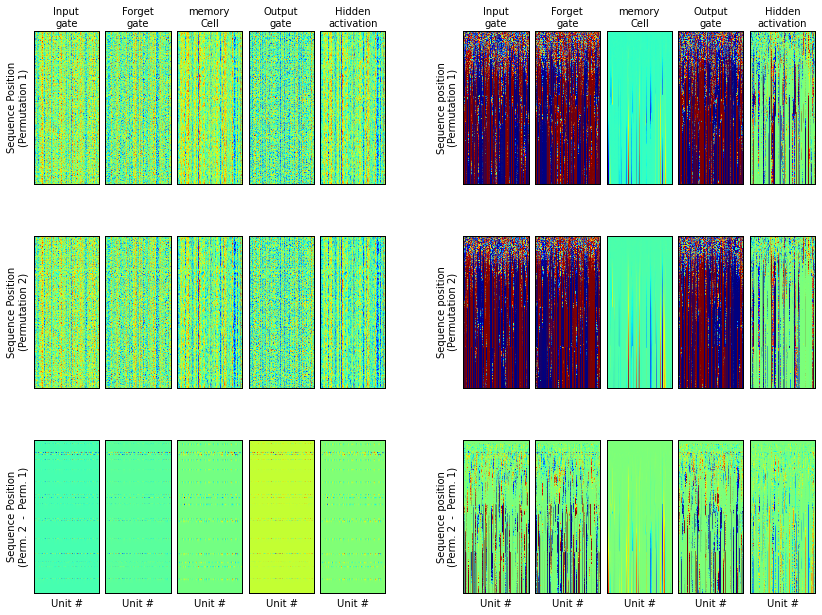

In [118]:
fig = plt.figure(figsize=(14,11))
fig.subplots_adjust(wspace=0.1, hspace=0.0001)

fSize = 10

labels = ['Input\ngate','Forget\ngate','memory\nCell','Output\ngate','Hidden\nactivation']


net.initialize_network_weights(scale_down=0.08, b_f_offset=0.0)
hidden_players = net.hidden_activations(vectors[:,:,:2])

ax_list1 = []
ax_list2 = []
ax_listD = []
for sp in range(len(labels)):
    ax_list1.append(fig.add_subplot(3,2*len(labels)+1,(0*(1+(2*len(labels))))+sp+1))
    ax_list2.append(fig.add_subplot(3,2*len(labels)+1,(1*(1+(2*len(labels))))+sp+1))
    ax_listD.append(fig.add_subplot(3,2*len(labels)+1,(2*(1+(2*len(labels))))+sp+1))

for ax,gtp,title in zip(ax_list1, hidden_players, labels):
    ax.imshow(gtp[:lengths[0],:,0])
    ax.set_title(title,{'fontsize':fSize})
    ax.set_yticks([])
    ax.set_xticks([])
    if title==labels[0]:
        ax.set_ylabel('Sequence Position\n(Permutation 1)',{'fontsize':10})
        
for ax,gtp,title in zip(ax_list2, hidden_players, labels):
    ax.imshow(gtp[:lengths[1],:,1])
    ax.set_yticks([])
    ax.set_xticks([])
    if title==labels[0]:
        ax.set_ylabel('Sequence Position\n(Permutation 2)',{'fontsize':fSize})
        
for ax,gtp,title in zip(ax_listD, hidden_players, labels):
    ax.imshow(gtp[:lengths[1],:,1] - gtp[:lengths[0],:,0])
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel('Unit #',{'fontsize':fSize})
    if title==labels[0]:
        ax.set_ylabel('Sequence Position\n(Perm. 2  -  Perm. 1)',{'fontsize':10})
        
avgD1 = np.mean(np.abs(hidden_players[4][:lengths[1],:,1]-hidden_players[4][:lengths[0],:,0]),axis=1)



net.initialize_network_weights(scale_down=0.6, b_f_offset=0.75)
hidden_players = net.hidden_activations(vectors[:,:,:2])

ax_list1 = []
ax_list2 = []
ax_listD = []
for sp in range(len(labels)):
    ax_list1.append(fig.add_subplot(3,2*len(labels)+1,1+(0*(1+(2*len(labels))))+sp+1+len(labels)))
    ax_list2.append(fig.add_subplot(3,2*len(labels)+1,1+(1*(1+(2*len(labels))))+sp+1+len(labels)))
    ax_listD.append(fig.add_subplot(3,2*len(labels)+1,1+(2*(1+(2*len(labels))))+sp+1+len(labels)))

for ax,gtp,title in zip(ax_list1, hidden_players, labels):
    ax.imshow(gtp[:lengths[0],:,0])
    ax.set_title(title,{'fontsize':fSize})
    ax.set_yticks([])
    ax.set_xticks([])
    if title==labels[0]:
        ax.set_ylabel('Sequence position\n(Permutation 1)',{'fontsize':10})
        
for ax,gtp,title in zip(ax_list2, hidden_players, labels):
    ax.imshow(gtp[:lengths[1],:,1])
    ax.set_yticks([])
    ax.set_xticks([])
    if title==labels[0]:
        ax.set_ylabel('Sequence position\n(Permutation 2)',{'fontsize':fSize})
        
for ax,gtp,title in zip(ax_listD, hidden_players, labels):
    ax.imshow(gtp[:lengths[1],:,1] - gtp[:lengths[0],:,0])
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel('Unit #',{'fontsize':fSize})
    if title==labels[0]:
        ax.set_ylabel('Sequence position\n(Perm. 2  -  Perm. 1)',{'fontsize':10})
    
avgD2 = np.mean(np.abs(hidden_players[4][:lengths[1],:,1]-hidden_players[4][:lengths[0],:,0]),axis=1)



fig.savefig('../data/activation_plots.png', transparent=True, dpi=600, bbox_inches='tight')

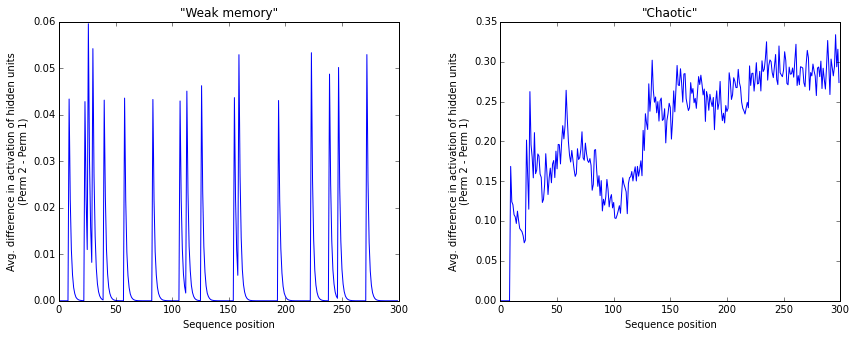

In [119]:
fig = plt.figure(figsize=(14,5))
fig.subplots_adjust(wspace=0.3)

axD = fig.add_subplot(1,2,1)
axD.plot( avgD1 );
axD.set_xlim([0,lengths[0]]);
axD.set_xlabel('Sequence position');
axD.set_ylabel('Avg. difference in activation of hidden units\n(Perm 2 - Perm 1)');
axD.set_title('"Weak memory"');

axD = fig.add_subplot(1,2,2)
axD.plot( avgD2 );
axD.set_xlim([0,lengths[0]]);
axD.set_xlabel('Sequence position');
axD.set_ylabel('Avg. difference in activation of hidden units\n(Perm 2 - Perm 1)');
axD.set_title('"Chaotic"');


fig.savefig('../data/action_potential_plots.png', transparent=True, dpi=600, bbox_inches='tight')

In [122]:
doc_len = []
for v in data_butler.doc_dict.itervalues():
    doc_len += [len(v['tags'])]

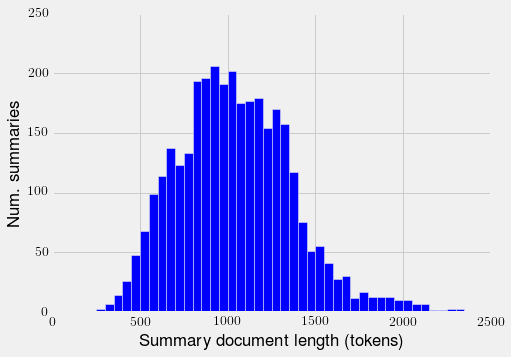

In [130]:
import matplotlib
plt.style.use('fivethirtyeight')
matplotlib.rcParams['text.usetex']=True

fig = plt.figure(figsize=(7,5));

bwid = 50

x = np.arange(0, 2500. + bwid, bwid)
b = x[0:-1]
H = np.histogram(doc_len,x);

ax = plt.axes();
ax.bar(b,H[0],bwid);
ax.set_xlabel('Summary document length (tokens)');
ax.set_ylabel('Num. summaries');
ax.set_xlim([-1,max(x)]);

fig.savefig('../data/doc_length_hist.png', transparent=True, dpi=600, bbox_inches='tight')